In [1]:
!nvidia-smi

Sat Mar 23 09:09:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |    941MiB / 15079MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gc
from os.path import join as pjoin
import os
from datetime import datetime
import time

In [3]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy
import torch

## Prepare for loging

In [4]:
import json
import os.path
import re
import ipykernel
import requests


from requests.compat import urljoin

from notebook.notebookapp import list_running_servers

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path


from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')



In [5]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
MODEL_NAME = get_notebook_name().split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
save_folder = f"{version:0>3d}" +'.'+date
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,save_folder)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/vgg_16bn-fastai/000.23-03-2019-09-09'

In [6]:
model_save_dir

'train_log/vgg_16bn-fastai/000.23-03-2019-09-09'

In [7]:
print(f"""
Note for version {version} model {MODEL_NAME}:

""")


Note for version 0 model vgg_16bn-fastai:




### Init data loader

In [8]:
data_path = '/home/qnkhuat/data/emotion_compilation_split'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=48,ds_tfms=tfms,bs=256)
       .normalize())

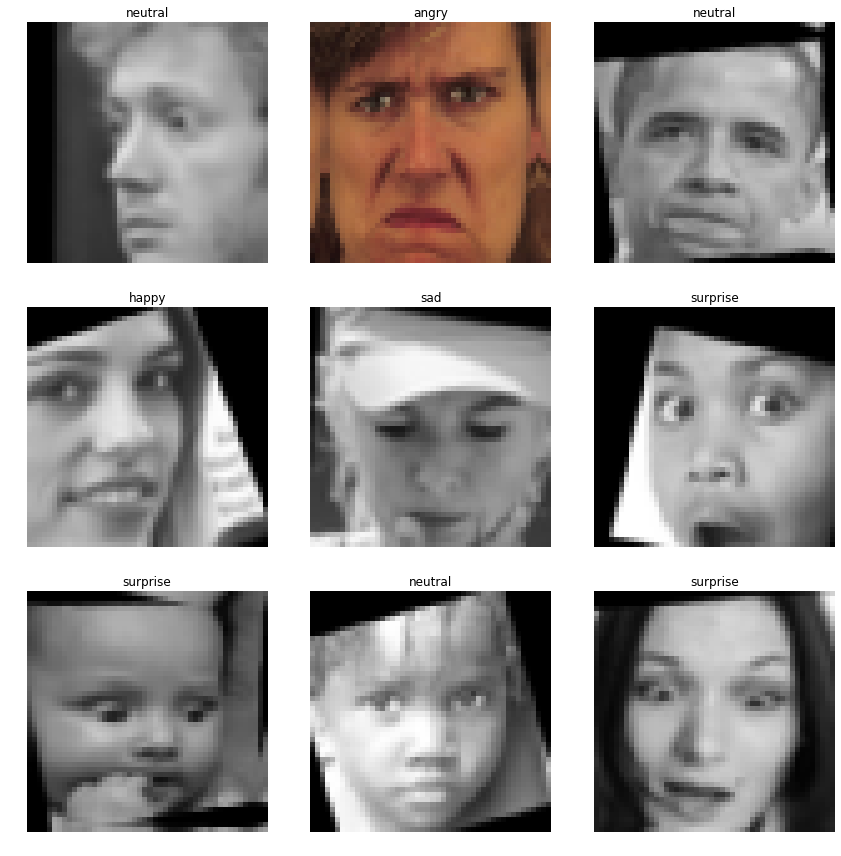

In [9]:
data.show_batch(rows=3)

## Init model

In [10]:
model = models.vgg16_bn

In [11]:
learn = cnn_learner(data, model)

In [12]:
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.model_dir = os.path.abspath(model_save_dir)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


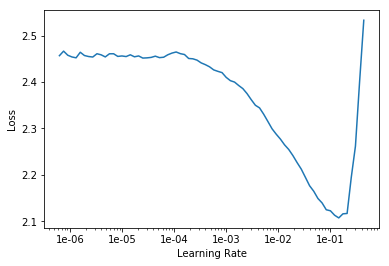

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
lr=5e-2

In [15]:
learn.metrics = [accuracy]

## Start training

In [16]:
learn.fit_one_cycle(12,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.576108,1.335237,0.509702,00:48
1,1.313421,1.138598,0.610321,00:49
2,1.101814,0.947507,0.659480,00:47
3,0.986071,0.856203,0.696996,00:47
4,0.917487,0.894651,0.684778,00:48
5,0.862282,0.809969,0.716832,00:45
6,0.814959,0.740044,0.736956,00:47
7,0.775739,0.690985,0.749748,00:48
8,0.739155,0.679993,0.751186,00:48
9,0.706320,0.654830,0.764841,00:48


In [17]:
#learn.fit(12,lr)

In [18]:
learn.save('stage-1')

#### Unfreeze 

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


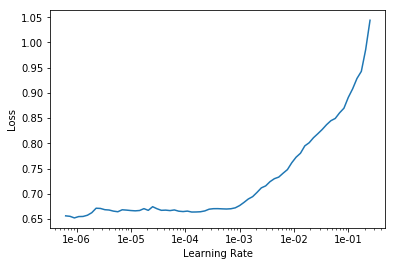

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr=1e-5

In [22]:
learn.fit(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.673728,0.654524,0.776915,00:55
1,0.579253,0.563638,0.805088,00:53
2,0.511233,0.567383,0.802214,00:53
3,0.491731,0.571170,0.792439,00:52
4,0.458901,0.505185,0.813857,00:50
5,0.426358,0.495042,0.824062,00:52
6,0.402367,0.524317,0.810982,00:53
7,0.382225,0.562983,0.806238,00:51
8,0.367147,0.508185,0.821762,00:52
9,0.357282,0.525836,0.821044,00:55


In [23]:
learn.save('stage-2')

#### Refreeze

In [24]:
learn.freeze()

In [25]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,accuracy,time
0,0.238162,0.477098,0.849935,00:48
1,0.221096,0.486675,0.850941,00:45
2,0.217757,0.475823,0.849504,00:48
3,0.206622,0.483621,0.851085,00:48
4,0.202818,0.479530,0.852666,00:47
5,0.198907,0.477342,0.851085,00:48
6,0.193203,0.480719,0.853529,00:47
7,0.193458,0.479401,0.852379,00:48
8,0.192713,0.482889,0.851948,00:48


In [26]:
learn.save('stage-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


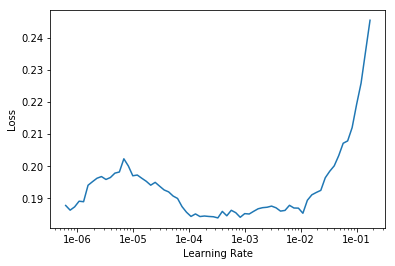

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit(10,lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.186018,0.479889,0.852379,00:50
1,0.188510,0.480265,0.852235,00:47
2,0.193435,0.479004,0.852810,00:50
3,0.191428,0.479535,0.852235,00:49
4,0.191176,0.479540,0.853098,00:47
5,0.190216,0.478532,0.852810,00:48
6,0.185636,0.477279,0.853529,00:48
7,0.190900,0.480912,0.851948,00:44
8,0.188129,0.478308,0.853241,00:41
9,0.194266,0.479746,0.851948,00:41


In [29]:
learn.save('stage-5')

In [30]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

85.99971532821655


# Remember to save the checkpoint before run this

In [31]:
notebook_save()
time.sleep(3) # to save the checkpoint
nb_name = model_save_dir+'_acc_'+str(tta)[:4]+'.html'
os.system(f"jupyter nbconvert {get_notebook_name()} --output {nb_name}")
nb_name

This notebook has been saved


'train_log/vgg_16bn-fastai/000.23-03-2019-09-09_acc_85.9.html'